In [1]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ergodicpy as ep
import scipy as sp
from scipy.stats import chi2_contingency

SAVE_FIGURES = False
x_points = 20
BOOST = 420 # for 2 dof
BOOST = 280 # for 1

# Code for plots - analysis below

In [2]:
def rn(hists):
    """ Row normalize """
    hists = np.array(hists)
    return (hists/hists.sum(axis=1)[:, np.newaxis])
    
def grid(rs):
    return [(0, 0), (1, int(len(rs)/2)), (2, -1)]
    
def plot_hists(func, xs, hs, hue_label='h'):
    """ Plots the heatmaps """
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    for ix, x in grid(xs):
        for ih, h in grid(hs):
            hists = func(xs[x], hs[h])
            g = sns.heatmap(data=hists, ax=axes[ih][ix])
            g.set_title("x=%s, %s=%s" % (xs[x], hue_label, hs[h]))
    
    
def plot(data, x='x', hue='hue'):
    """ Plots Chi2 Tau2 """
    d = data[0].copy()
    del d[x]
    del d[hue]
    
    fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10,10))
    df = pd.DataFrame(data)
    
    # chi2
    g = sns.lineplot(data=df, x=x, y='chi2', ax=axes[0][0], hue=hue)
    g.set(title='Chi2', ylabel=None)
    
    g = sns.lineplot(data=df, x=x, y='chi2_p', ax=axes[0][1], hue=hue, legend=False)
    axes[0][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05), title='Chi2 p-value', ylabel=None)
    
    # tau
    g = sns.lineplot(data=df, x=x, y='tau2', ax=axes[1][0], hue=hue, legend=False)
    g.set(title='Tau2', ylabel=None)
    
    g = sns.lineplot(data=df, x=x, y='tau2_p', ax=axes[1][1], hue=hue, legend=False)
    axes[1][1].axhline(y=0.05, color='grey', linestyle='dotted')
    g.set(ylim=(-0.05,1.05), title='Tau2 p-value', ylabel=None)
    
    return fig

def compare(x_range, hue_range, hist_func, hue_label, name=None, boost=BOOST, hist_plot=True, flat_weights=False):
    data = []
    for hue in hue_range:
        for x in x_range:
            hists = hist_func(x, hue)
            
            # change default weight behaviour
            if flat_weights:
                weights = np.ones(len(hists))
            else:
                weights = None
            
            # analyse
            measures = ep.measures(hists, tau_boost=boost, weights=weights, with_meta=True)
            chi2, p, _, _ = sp.stats.chi2_contingency(hists)

            # store
            data.append({
                'chi2': chi2,
                'chi2_p': p,
                'tau2': measures['tau2'],
                'tau2_p': measures['tau2p'],
                'x': x,
                hue_label : hue,
            })
    
    fig = plot(data, hue=hue_label)
    if SAVE_FIGURES and name is not None:
        fig.savefig("figures/%s.eps" % name)
    
    if hist_plot:
        plot_hists(hist_func, x_range, hue_range, hue_label)

# Ensembles

- First we look at the impact of increasing number of ensembles, this can be thought of as rows in a Chi2 contingency table.
- We plot `x` on the x-axis. Which represents increasing heterogenity (or ergodic complexity) for the created distributions.
- We do this for observation sets with multiple different numbers of ensembles.
- Below this is a visualisation of the generated distributions. Top left representating least x and least ensembles, bottom right most x and most ensembles.

## Uniform additional ensembles

- First we add increasing numbers of ensembles.
- To create heterogenity there is a uniform dist and a non-uniform (by x)
- To keep things are uniform as possible, for increasing ensembles we add both the uniform and non-uniform dists. So conceptually it's like splitting the observations in half and treating them like different ensembles.

- What we find is p-value for Chi2 (`Chi2p`) is broadly consistent although suffers from some variation.
- While Tau2p is entirely invariant.

In [3]:
def uniform_ensembles(x, h):
    hist = rn([[1, 1+x*(i%2)] for i in range(2*h)])
    return hist*10

print(uniform_ensembles(0.2, 1).sum())
print(uniform_ensembles(0.2, 2).sum())
print(uniform_ensembles(0.2, 4).sum())

20.0
40.0
80.0


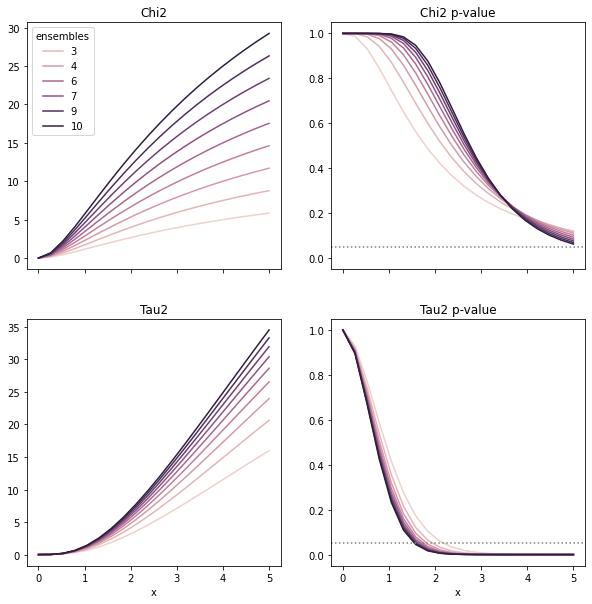

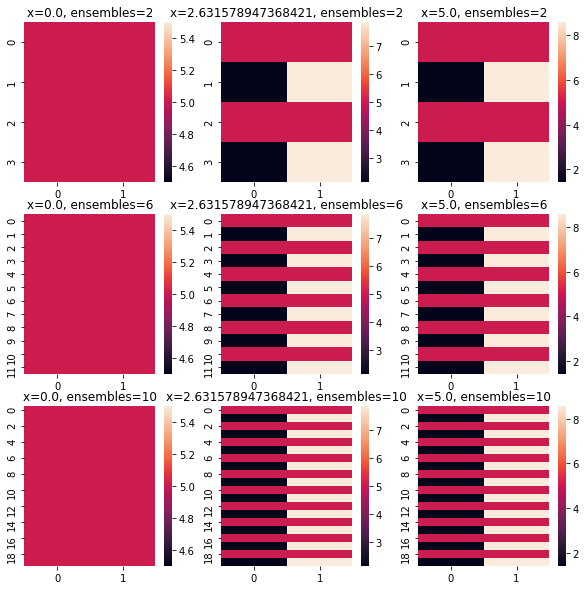

In [4]:
compare(np.linspace(0,5,x_points), ep.binint(2,10,20), uniform_ensembles, 'ensembles')

Should be more ensembles, more confidence they're different. But Chi2 has more confidence the fewer the ensembles.

99.99999999999999
100.0
100.0


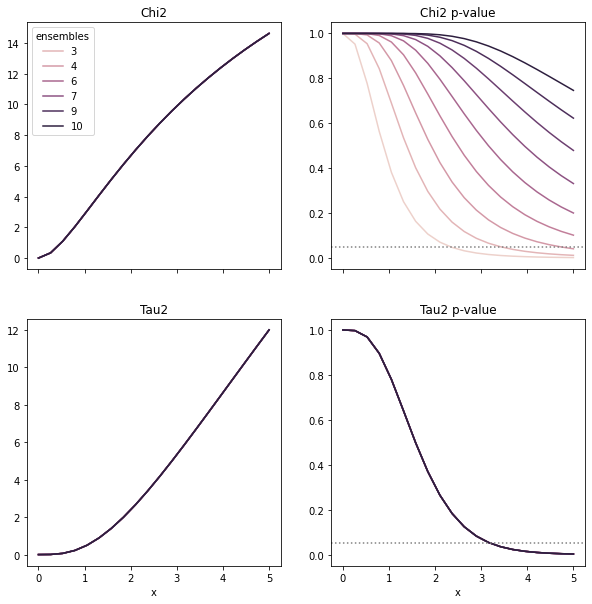

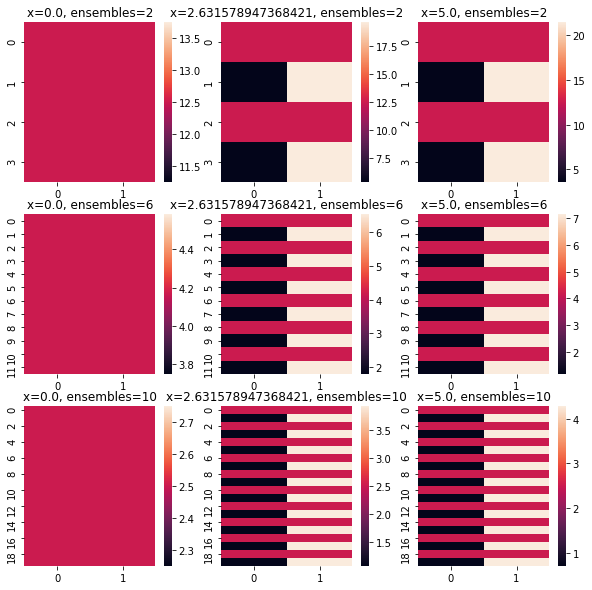

In [73]:
def uniform_ensembles_norm(x, h):
    hist = rn([[1, 1+x*(i%2)] for i in range(2*h)])
    return hist*100/hist.sum()

print(uniform_ensembles_norm(0.2, 1).sum())
print(uniform_ensembles_norm(0.2, 2).sum())
print(uniform_ensembles_norm(0.2, 4).sum())
compare(np.linspace(0,5,x_points), ep.binint(2,10,20), uniform_ensembles_norm, 'ensembles')

## Linear additional additions

- Here we add additional ensembles but where each ensemble is different from a graded perspective but normalised.
- So the difference between two ensembles is high, while the difference between many ensembles has a mix of low and high differences. (see the heatmaps for a visualisation).
- The total number of observations across all ensembles was kept consistent.

- What we find here is Chi2p is highly sensitive to the number of ensembles.
- While Tau2p is no longer invariant, but is less sensitive.

In [80]:
def ensemble_hists(x, ensembles):
    hist = np.array([[0.1,1+x*e/ensembles] for e in range(ensembles)])
    return hist*10000/(hist.sum())

print("%s total obs, across 2 ensembles" % ensemble_hists(0.1, 2).sum())
print(ensemble_hists(0.1, 2))
print("%s total obs, across 4 ensembles" % ensemble_hists(0.1, 4).sum())
print(ensemble_hists(0.1, 4))

10000.0 total obs, across 2 ensembles
[[ 444.44444444 4444.44444444]
 [ 444.44444444 4666.66666667]]
10000.0 total obs, across 4 ensembles
[[ 219.78021978 2197.8021978 ]
 [ 219.78021978 2252.74725275]
 [ 219.78021978 2307.69230769]
 [ 219.78021978 2362.63736264]]


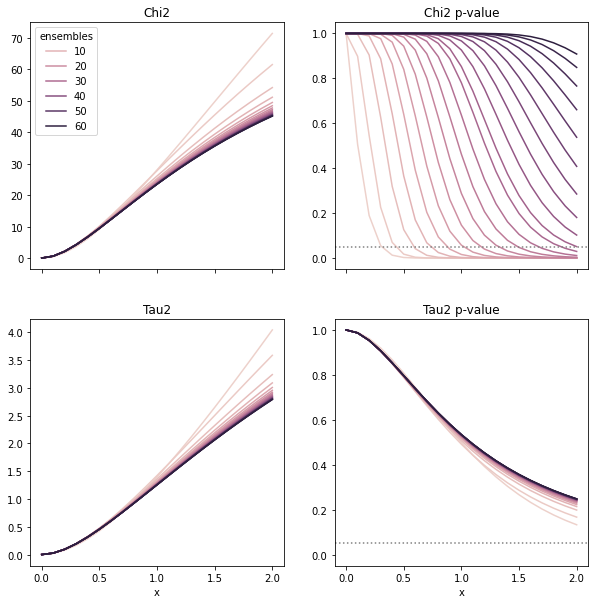

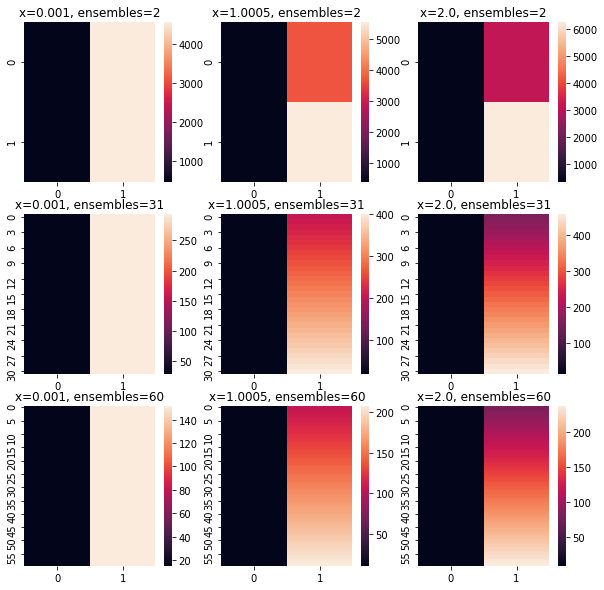

In [81]:
compare(ep.binspace(0.001,2.0,x_points), ep.binint(2,60,20), ensemble_hists, 'ensembles')

## Linear additions with consistent observations

- Interestingly, Chi2 is highly sensitive to the number of observations.
- It is typically thought that Chi2 is senstive to the number of ensembles & states (called degrees of freedom in it's terminology), but it appears observations play a much greater role.
- We can see this below, where the linear addition as done above is now longer consistent in terms of observations for all distributions (i.e. N is constant), instead if we keep the total number of observations per ensemble consistent (i.e. N_k is constant), then Chi2p falls in lines with Tau2p becoming broadly consistent (but not invariant as the distributions are very slightly different).
- Here the increasing (equal) sized ensembles act to boost Chi2, so that the degree's of freedom are offset in the Chi2 distribution to get the p-value.

In [40]:
def ensemble_hists_linear(x, h):
    hist = np.array([[0.1,1+x*e/h] for e in range(h)])
    return rn(hist)*300

for i in range(1,5):
    print("%s observations per ensemble, (%s ensembles)" % (ensemble_hists_linear(0.1, i).sum()/i, i))

299.99999999999994 observations per ensemble, (1 ensembles)
300.0 observations per ensemble, (2 ensembles)
299.99999999999994 observations per ensemble, (3 ensembles)
300.0 observations per ensemble, (4 ensembles)


Chi2 interrepts this incorrectly. Since with fewer ensembles, there's a higher absolute difference between the ensembles.

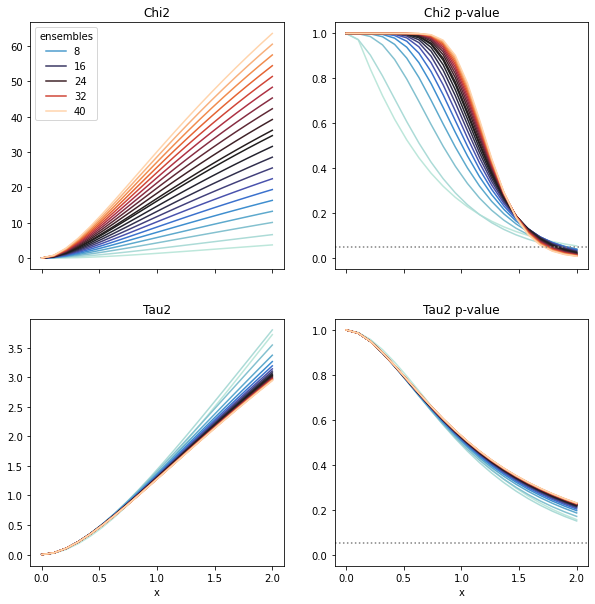

In [66]:
compare(np.linspace(0,2,x_points), ep.binint(2,40,20), ensemble_hists_linear, 'ensembles',hist_plot=False)

- However, it is worth noting when the number of ensembles is proportional to the number of observations, that is the number of observations per ensemble is kept constant, then the results become (broadly) invariant.
- Meaning introducing more ensembles with the same number of observations doesn't affect the results.
- In this case, since Tau2 is invariant to the total number of observations, it is invariant in this case too.

# Observations count

- Below we do the same as we did with ensembles, however this time increasing the number of observations for various methods of increasing heterogenity with x.
- What we find is Tau2p is invariant to the number of observations (which makes sense as we're using entropy where we transform the histograms into probability mass functions first).
- However, Chi2p is highly depedant on observations. Where in particular the fewer the observations, the less it thinks the distributions are heterogenious. This is might be a positive intended consequence when you're trying to prove that a drug works (where the positive case is sort after) as it encourages a greater volume of human samples. 

Null Hypothesis (H0): The sample data occurs purely from chance.
Alternative Hypothesis (HA): The sample data is influenced by some non-random cause.

If the p-value of the hypothesis test is less than some significance level (e.g. α = .05), then we can reject the null hypothesis and conclude that we have sufficient evidence to say that the alternative hypothesis is true.

If the p-value is not less than .05, then we fail to reject the null hypothesis and conclude that we do not have sufficient evidence to say that the alternative hypothesis is true.

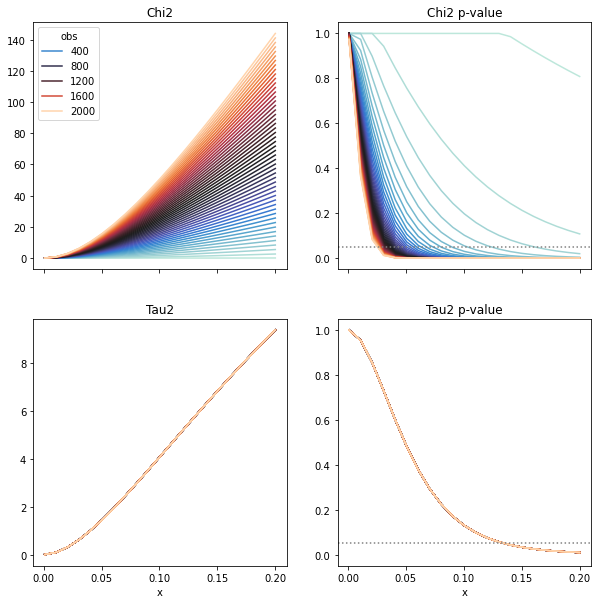

In [67]:
compare(ep.binspace(0.001,0.2,x_points), ep.binint(10,2000,50), lambda x, h: rn(np.array([[0.1,1],[0.1+x,1]]))*h, 'obs', hist_plot=False)

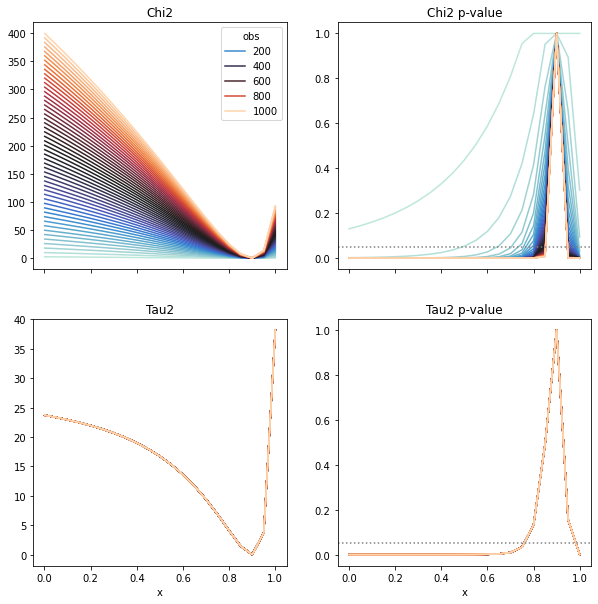

In [68]:
compare(ep.binspace(0.001,1.0,x_points), ep.binint(10,1000,50), lambda x, h: rn([[0.1,1],[1-x,1]])*h, 'obs',hist_plot=False)

# States

- Here we investigate what adding additional states (columns in a chi2 contingency table) does.

## Uniform additional states

- Here we do similarly as the uniform ensembles, effectively splitting each states (bin) into 2 equal parts. So the overall heterogenity is not increasing, but our granularity is.
- What we find is Tau2 and Tau2p are both invariant to increasing states.
- Interestingly, Chi2 is also invariant, but because states are counted as part of the degree's of freedom, it adjusts the distribution to no longer be invariant.

In [3]:
def state_hist_uniform(x, states):
    return rn([
        np.ones(states*2),
        np.concatenate([np.ones(states)*(1-x), np.ones(states)*x]),
    ])*100

# normalised number of observations
# effectively taking a [p,q] state and splitting it into [p/2,p/2,q/2,q/2] etc
print(state_hist_uniform(0.2,1), state_hist_uniform(0.5,1).sum())
print(state_hist_uniform(0.2,2), state_hist_uniform(0.5,2).sum())

[[50. 50.]
 [80. 20.]] 200.0
[[25. 25. 25. 25.]
 [40. 40. 10. 10.]] 200.0


Here Chi2 intrepts this correctly, as treats it the same as ensembles when it shouldn't for our use case. Here the fewer the states, the more confident that they are heterogenious (aka dependant).

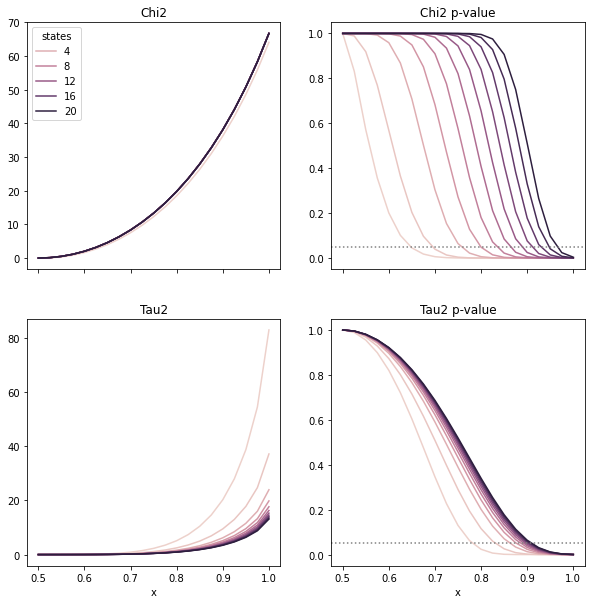

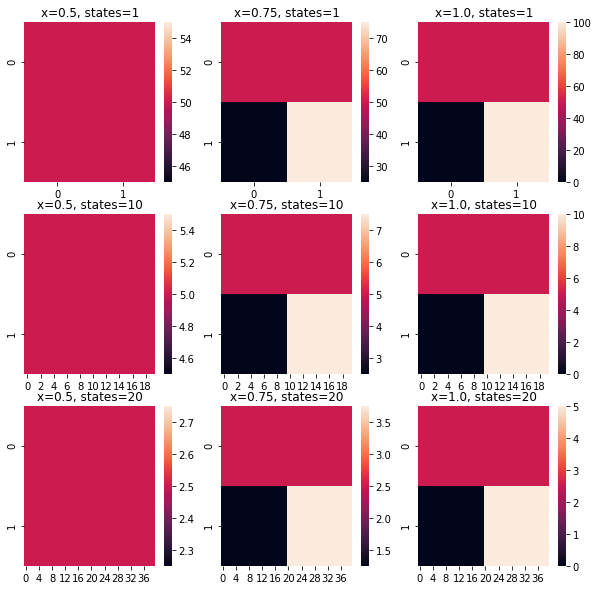

In [4]:
compare(ep.binspace(0.5,1.0,x_points), ep.binint(1,20,10), state_hist_uniform, 'states')

In [46]:
def state_hist_uniform_increment(x, states):
    return rn([
        np.ones(states*2),
        np.concatenate([np.ones(states)*(1-x), np.ones(states)*x]),
    ])*10*states

print(state_hist_uniform_increment(0.1,2), state_hist_uniform_increment(0.1,2).sum(axis=1))
print(state_hist_uniform_increment(0.1,1), state_hist_uniform_increment(0.1,1).sum(axis=1))

[[5. 5. 5. 5.]
 [9. 9. 1. 1.]] [20. 20.]
[[5. 5.]
 [9. 1.]] [10. 10.]


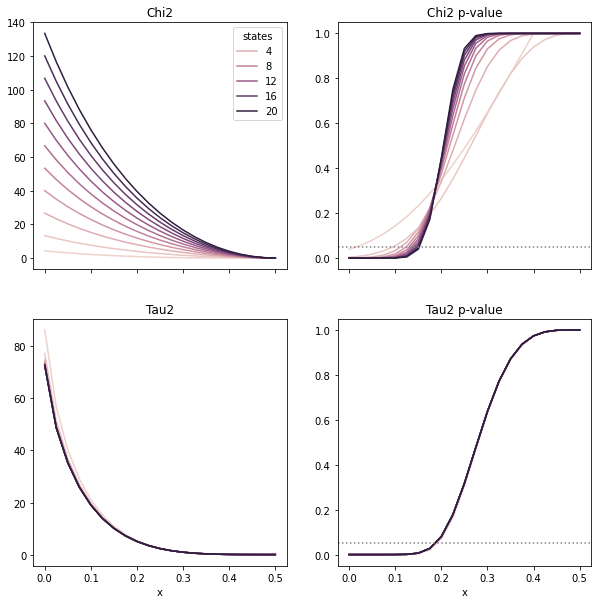

In [47]:
compare(ep.binspace(0,0.5,x_points), ep.binint(1,20,10), state_hist_uniform_increment, 'states', hist_plot=False)

## Linear additions

Similarly for linear additions we find

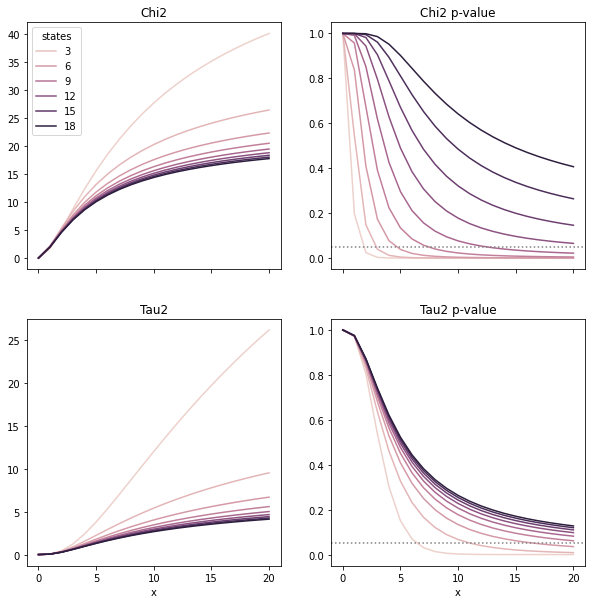

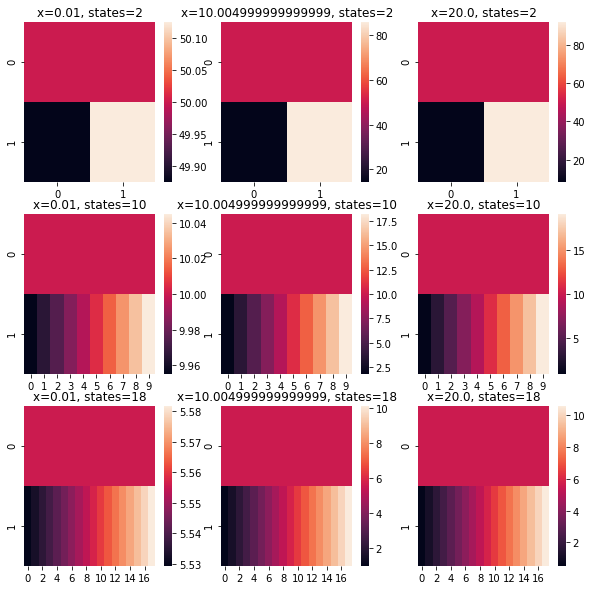

In [48]:
compare(ep.binspace(0.01,20.0,x_points), range(2,20,2), lambda x,h: rn([np.ones(h), [1+x*k/h for k in range(h)]])*100, 'states')

# Weights for observations

- Chi2 has a weighting mechanism built in as it uses raw frequency data
- Tau2 uses weights, which is similar to adjusting the frequency of a particular row
- The default weights are the sum of the observations for that ensemble row (N_k) by the total observations across all ensembles (N_k/N)

In [49]:
def weighted_hist(x, h):
    hists = np.array([[h,h],[1+x,1]]) # just focus on absolute difference between ensembles
    hists /= hists.sum() # normalise to account for obs count differences
    return hists*80 # have to multiply by a decent obs count as chi2 sensitive to absolute obs

def weighted_hist_not_norm(x, h):
    hists = np.array([[h,h],[1+x,1]])
    return hists*10

print(weighted_hist(0.1,10))
print(weighted_hist_not_norm(0.1,10))

[[36.19909502 36.19909502]
 [ 3.98190045  3.6199095 ]]
[[100. 100.]
 [ 11.  10.]]


- Here Chi2 & Tau2 behave similarly
- Here we compare histograms with an increasing difference in the absolute counts across ensmebles
- Meaning the flat ensemble becomes more dominant
- In reality this could be because either that ensemble is easier to get data for therefore the absolute counts are higher or it could be biases in sampling etc
- Chi2 & Tau2 (by default) take these differences into account in the same way, assuming that ensembles with smaller absolute counts exist less in the world and therefore contribute to the heterogenity of the system less also

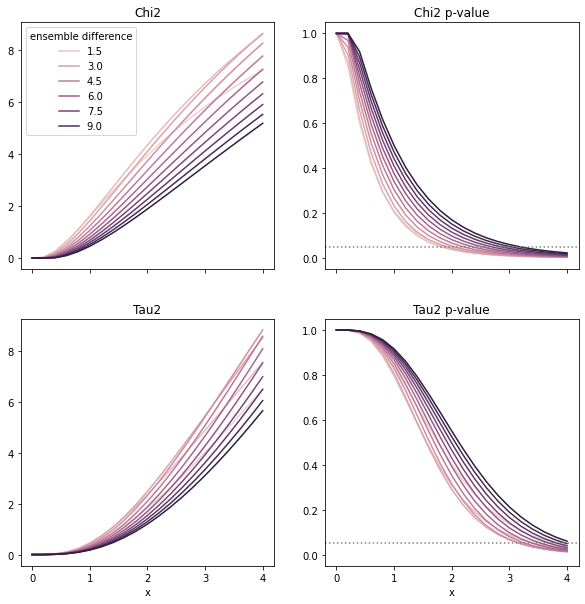

In [50]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist, 'ensemble difference', hist_plot=False)

However, with Tau2 this assumed behaviour can be turned off by setting the weights to all be equal

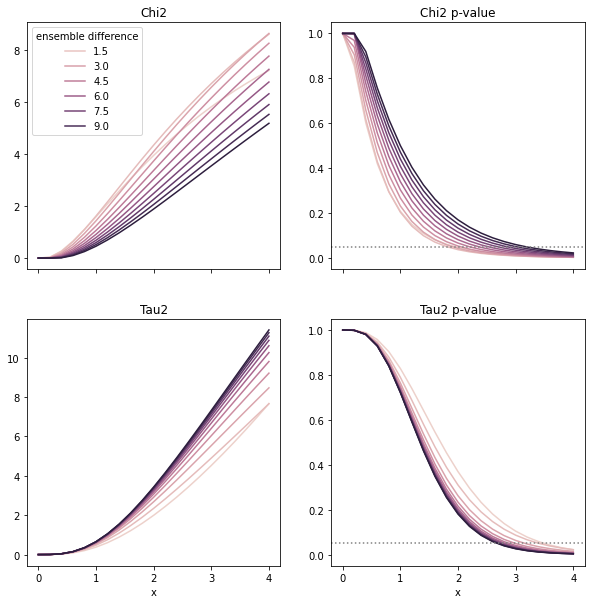

In [51]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist, 'ensemble difference', flat_weights=True, hist_plot=False)

Interestingly, you can also "turn off" this behaviour with Chi2 also. In the first example we normalise the total count of all observations, because Chi2 is sensitive to the total number of observations. However, if we no longer do this, the increase in the number of total observations cancels out the differences between ensembles.

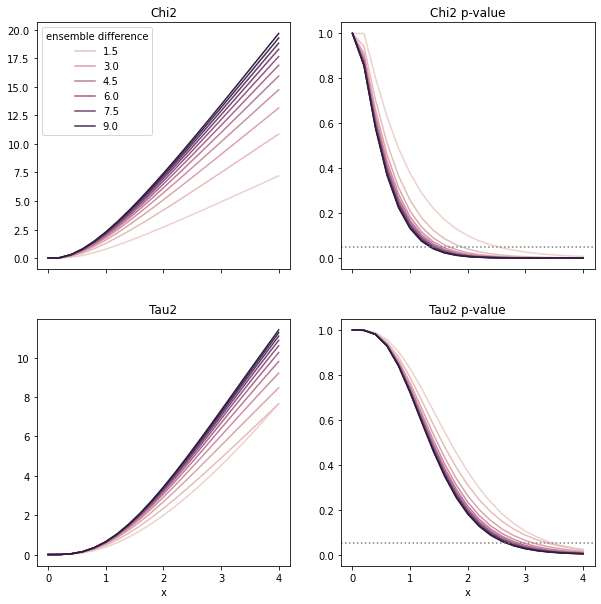

In [52]:
compare(ep.binspace(0.001,4,x_points), ep.binspace(1,10,10), weighted_hist_not_norm, 'ensemble difference', flat_weights=True, hist_plot=False)

This can be thought of conceptually as if you have an ensemble (A) with (2x) the observations as (B) with (1x), you could see this as three ensembles (Ai, Aii, B) each with equal observations. Since in this case, we would see a single outlier ensemble as making the system less complex it is appropriate to weight in this way.